# Import Data

In [1]:
%cd '/Users/siyu/Downloads'
import pandas as pd
dr_lab=pd.read_csv("dr_lab.csv")

/Users/siyu/Downloads


In [2]:
str(dr_lab.encounter_id)

'0             1445224\n1             1445224\n2             1445087\n3             1445087\n4             1566664\n              ...    \n55256065    368098637\n55256066    368098637\n55256067    368098637\n55256068    368098637\n55256069    368098637\nName: encounter_id, Length: 55256070, dtype: int64'

In [3]:
#no_dr_lab=pd.read_csv("no_dr_lab.csv")
DEncounter=pd.read_csv("DEncounter_reduced.csv",delimiter = "\t")
Diagnosis=pd.read_csv("Diagnosis_reduced1.csv",delimiter = "\t")

In [4]:
DEncounter.columns=DEncounter.columns.str.lower()

# Delete blank records and transform data type of certain columns

In [5]:
DEncounter.isnull().sum()

encounter_id            1
patient_sk              1
race              2466851
gender               6791
age_in_years      1938386
admitted_dt_tm    1828783
dtype: int64

In [6]:
DEncounter.dropna(inplace=True)

In [7]:
DEncounter.encounter_id=DEncounter.encounter_id.astype(int)
DEncounter.patient_sk=DEncounter.patient_sk.astype(int)

In [8]:
Diagnosis.columns=Diagnosis.columns.str.lower()

In [9]:
Diagnosis.dropna(inplace=True)

In [10]:
Diagnosis.encounter_id=Diagnosis.encounter_id.astype(int)
Diagnosis.diagnosis_priority=Diagnosis.diagnosis_priority.astype(int)

# Find all the DR dignosis encounter then locate all the target patients

In [11]:
Diagnosis_target=Diagnosis[Diagnosis.diagnosis_code.isin(["362.0", "362.01", "362.02", "362.03", "362.04", "362.05", "362.06",
                                                         "E11.311", "E11.319", "E11.3211", "E11.3212", "E11.3213", "E11.3219", 
                                                          "E11.3291", "E11.3293", "E11.3299", "E11.3311", "E11.3312", "E11.3313", 
                                                          "E11.3319", "E11.3391", "E11.3392", "E11.3393", "E11.3399", "E11.3411", 
                                                          "E11.3412", "E11.3413", "E11.3419", "E11.3491", "E11.3492", "E11.3493",
                                                          "E11.3499", "E11.3511", "E11.3512", "E11.3513", "E11.3519", "E11.3521", 
                                                          "E11.3522", "E11.3523", "E11.3529", "E11.3531", "E11.3532", 
                                                          "E11.3533", "E11.3539", "E11.3541", "E11.3542", "E11.3543", "E11.3549", 
                                                          "E11.3551", "E11.3552", "E11.3553", "E11.3559", "E11.3591", "E11.3592", 
                                                          "E11.3593", "E11.3599", "E10.311", "E10.319", "E10.3211", "E10.3212", 
                                                          "E10.3213", "E10.3219", "E10.3291", "E10.3293", "E10.3299", "E10.3311", 
                                                          "E10.3312", "E10.3313", "E10.3319", "E10.3392", "E10.3393", "E10.3399", 
                                                          "E10.3411", "E10.3412", "E10.3419", "E10.3491", "E10.3492", "E10.3493", 
                                                          "E10.3499", "E10.3511", "E10.3512", "E10.3513", "E10.3519", "E10.3521", 
                                                          "E10.3522", "E10.3523", "E10.3529", "E10.3531", "E10.3532", "E10.3533", 
                                                          "E10.3539", "E10.3541", "E10.3542", "E10.3543", "E10.3549", "E10.3551", 
                                                          "E10.3552", "E10.3553", "E10.3559", "E10.3591", "E10.3592", "E10.3593", 
                                                          "E10.3599"])]

In [12]:
new=dr_lab.encounter_id.isin(Diagnosis_target.encounter_id.unique())
target_patient_key=dr_lab[new].patient_sk.unique()
patient_new=dr_lab.patient_sk.isin(target_patient_key)
dr_patient_new=dr_lab[patient_new]

## Create a new variable to indicate whether patient is diagnosed as DR during that encounter 

In [13]:
dr_patient_new['dr_encounter']=dr_patient_new.encounter_id.isin(Diagnosis_target.encounter_id.unique())
dr_patient_new.dr_encounter=dr_patient_new.dr_encounter.astype(int)

/var/folders/2n/wy2j47ss1lb443rj3f6dmkzw0000gn/T/ipykernel_6950/3310620989.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr_patient_new['dr_encounter']=dr_patient_new.encounter_id.isin(Diagnosis_target.encounter_id.unique())
/Users/siyu/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


## Merge dr patient lab results and demographic information

In [14]:
dr_sort=dr_patient_new.sort_values(by='lab_verified_dt_tm')

In [15]:
dr=pd.merge(dr_sort,DEncounter,how="left",on="encounter_id")

In [16]:
dr.drop(columns='patient_sk_y',inplace=True)

In [17]:
dr.rename(columns={"patient_sk_x": "patient_sk"},inplace=True)

# Creatinine data construction

In [18]:
dr_creat=dr[dr["lab_procedure_name"]=='Creatinine, Serum Quantitative']
dr_creat=dr_creat.sort_values(by=['patient_sk','lab_verified_dt_tm']).dropna()
dr_creat_prep=dr_creat.groupby("encounter_id").first().sort_values(by=['patient_sk','lab_verified_dt_tm']).reset_index()
dr_creat_mean=dr_creat.groupby('encounter_id').mean()
dr_creat_final=dr_creat_prep.merge(dr_creat_mean,how='left',on='encounter_id').drop(columns=['numeric_result_x','patient_sk_y','dr_encounter_y','age_in_years_y'])
dr_creat_final.rename(columns={'patient_sk_x':'patient_sk','dr_encounter_x':'dr_encounter','age_in_years_x':'age_in_years','numeric_result_y':'numeric_result'},inplace=True)

## Select all the information before and including the first DR diagnosis encounter

In [19]:
df_creat=pd.DataFrame()
for key in dr_creat_final.patient_sk.unique():
    if ((len(dr_creat_final[dr_creat_final.patient_sk==key].encounter_id.unique())>=3) and (dr_creat_final[dr_creat_final.patient_sk==key].dr_encounter.sum()>0)) :
        en_id=dr_creat_final[(dr_creat_final.patient_sk==key)&(dr_creat_final.dr_encounter==True)].iloc[0]["encounter_id"]
        time=dr_creat_final[dr_creat_final.encounter_id==en_id].lab_verified_dt_tm.max()
        df_patient=dr_creat_final[(dr_creat_final.patient_sk==key)&(dr_creat_final.lab_verified_dt_tm<=time)]
        df_creat=df_creat.append(df_patient,ignore_index=True)

## Find all patients who have at least 4 encounters including the first DR diagnosis encounter and keep the last 4 encounters' informatioin

In [39]:
countdf =df_creat.groupby('patient_sk').count()
df_creat_final = df_creat.loc[df_creat['patient_sk'].isin(countdf[countdf['encounter_id'] > 3].index)]

In [40]:
df_creat_final

,encounter_id,patient_sk,lab_procedure_name,unit,lab_verified_dt_tm,dr_encounter,race,gender,age_in_years,admitted_dt_tm,numeric_result
0,242007621,40184,"Creatinine, Serum Quantitative",mg/dL,2011-04-18 15:25:00.0000000,0,Caucasian,Male,52.0,2011-09-23 08:41:00.0000000,0.70
1,234836515,40184,"Creatinine, Serum Quantitative",mg/dL,2012-03-01 20:02:00.0000000,0,Caucasian,Male,52.0,2011-12-07 11:01:00.0000000,1.70
2,241488258,40184,"Creatinine, Serum Quantitative",mg/dL,2012-03-13 08:22:00.0000000,0,Caucasian,Male,53.0,2012-03-13 06:13:00.0000000,1.60
3,242047104,40184,"Creatinine, Serum Quantitative",mg/dL,2012-03-24 00:11:00.0000000,0,Caucasian,Male,52.0,2011-09-21 11:28:00.0000000,0.90
4,241110926,40184,"Creatinine, Serum Quantitative",mg/dL,2012-04-13 08:49:00.0000000,0,Caucasian,Male,53.0,2012-04-05 08:59:00.0000000,2.20
...,...,...,...,...,...,...,...,...,...,...,...
161908,445096412,104656321,"Creatinine, Serum Quantitative",mg/dL,2015-06-22 04:38:00.0000000,1,Caucasian,Male,48.0,2015-06-15 12:47:00.0000000,5.00
161923,444412882,104700366,"Creatinine, Serum Quantitative",mg/dL,2015-04-02 05:38:00.0000000,0,African American,Female,53.0,2015-03-30 01:10:00.0000000,3.29
161924,444676159,104700366,"Creatinine, Serum Quantitative",mg/dL,2015-04-15 04:49:00.0000000,0,African American,Female,53.0,2015-04-08 19:26:00.0000000,2.27
161925,444820403,104700366,"Creatinine, Serum Quantitative",mg/dL,2015-05-15 13:32:00.0000000,0,Caucasian,Female,53.0,2015-05-15 12:53:00.0000000,2.69


## Create a variable indicate the encounter order for each patient and using the mean of numeric result instead of the first measurement in each encounter to reduce measurement errors

In [41]:
df_creat_final=df_creat_final.reset_index()

In [42]:
df_creat_lt=df_creat_final.groupby('patient_sk').lab_verified_dt_tm.max().reset_index()

In [43]:
df_creat_lt=df_creat_lt.rename(columns={'lab_verified_dt_tm':'last_time'})

In [44]:
df_creat_merge=df_creat_final.merge(df_creat_lt,how='left',on='patient_sk')

In [48]:
df_creat_final=df_creat_merge.drop(columns='index')

## In order to use reverse alignment method, we need to let last encounter as time origin and calculate the time difference from origin.

In [52]:
df_creat_final['lab_verified_dt_tm']=pd.to_datetime(df_creat_final['lab_verified_dt_tm'])
df_creat_final['last_time']=pd.to_datetime(df_creat_final['last_time'])
df_creat_final['time_diff']=-(df_creat_final['last_time']-df_creat_final['lab_verified_dt_tm']).dt.days
df_creat_final['patient_sk']=df_creat_final.patient_sk.astype(str)

In [87]:
df_creat_final=df_creat_final[df_creat_final.patient_sk.isin(df_creat_final[df_creat_final['unit']=='mg/dL']['patient_sk'].unique())]

## Draw line plot to see the trend for each patient and a lmplot to observe the overall trend.

<AxesSubplot:xlabel='time_diff', ylabel='numeric_result'>

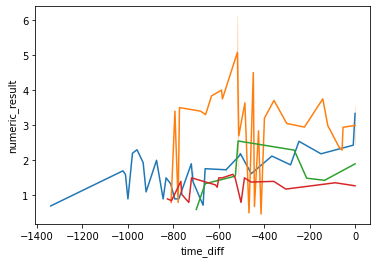

In [88]:
import seaborn as sns
sample_data=df_creat_final[df_creat_final.patient_sk.isin(df_creat_final.patient_sk.unique()[0:4])][['patient_sk','numeric_result','time_diff']]
sns.lineplot(data=sample_data, x="time_diff", y="numeric_result", hue="patient_sk",legend=False)

<AxesSubplot:xlabel='time_diff', ylabel='numeric_result'>

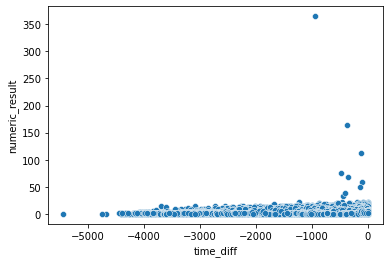

In [96]:
sns.scatterplot(data=df_creat_final,x="time_diff", y="numeric_result")

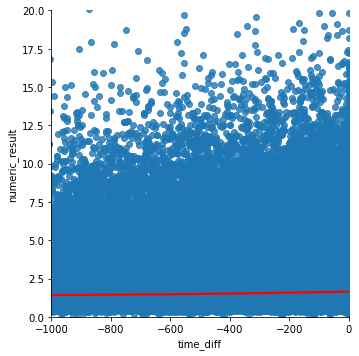

In [89]:
g1=sns.lmplot(data=df_creat_final,x="time_diff", y="numeric_result",lowess=True,line_kws={"color":"red"})
g1.set(xlim=(-1000,0),ylim=(0,20))

In [91]:
len(df_creat_final)

145014

# HbA1C data

In [63]:
dr_HbA1C=dr[dr["lab_procedure_name"]=='Hemoglobin A1C (Glycosylated Hemoglobin)']
dr_HbA1C=dr_HbA1C.sort_values(by=['patient_sk','lab_verified_dt_tm']).dropna()
dr_HbA1C=dr_HbA1C[dr_HbA1C['unit']=="%"]
dr_HbA1C_prep=dr_HbA1C.groupby("encounter_id").first().sort_values(by=['patient_sk','lab_verified_dt_tm']).reset_index()
dr_HbA1C_mean=dr_HbA1C.groupby('encounter_id').mean()
dr_HbA1C_final=dr_HbA1C_prep.merge(dr_HbA1C_mean,how='left',on='encounter_id').drop(columns=['numeric_result_x','patient_sk_y','dr_encounter_y','age_in_years_y'])
dr_HbA1C_final.rename(columns={'patient_sk_x':'patient_sk','dr_encounter_x':'dr_encounter','age_in_years_x':'age_in_years','numeric_result_y':'numeric_result'},inplace=True)

In [64]:
df_HbA1C=pd.DataFrame()
for key in dr_HbA1C.patient_sk.unique():
    if ((len(dr_HbA1C[dr_HbA1C.patient_sk==key].encounter_id.unique())>=3) and (dr_HbA1C[dr_HbA1C.patient_sk==key].dr_encounter.sum()>0)) :
        en_id=dr_HbA1C[(dr_HbA1C.patient_sk==key)&(dr_HbA1C.dr_encounter==True)].iloc[0]["encounter_id"]
        time=dr_HbA1C[dr_HbA1C.encounter_id==en_id].lab_verified_dt_tm.max()
        df_patient=dr_HbA1C[(dr_HbA1C.patient_sk==key)&(dr_HbA1C.lab_verified_dt_tm<=time)]
        df_HbA1C=df_HbA1C.append(df_patient,ignore_index=True)

In [65]:
countdf =df_HbA1C.groupby('patient_sk').count()
df_HbA1C_final = df_HbA1C.loc[df_HbA1C['patient_sk'].isin(countdf[countdf['encounter_id'] > 3].index)]

In [66]:
df_HbA1C_final=df_HbA1C_final.reset_index()
df_HbA1C_lt=df_HbA1C_final.groupby('patient_sk').lab_verified_dt_tm.max().reset_index()
df_HbA1C_lt=df_HbA1C_lt.rename(columns={'lab_verified_dt_tm':'last_time'})
df_HbA1C_merge=df_HbA1C_final.merge(df_HbA1C_lt,how='left',on='patient_sk')
df_HbA1C_final=df_HbA1C_merge.drop(columns='index')

In [67]:
df_HbA1C_final['lab_verified_dt_tm']=pd.to_datetime(df_HbA1C_final['lab_verified_dt_tm'])
df_HbA1C_final['last_time']=pd.to_datetime(df_HbA1C_final['last_time'])
df_HbA1C_final['time_diff']=-(df_HbA1C_final['last_time']-df_HbA1C_final['lab_verified_dt_tm']).dt.days
df_HbA1C_final['patient_sk']=df_HbA1C_final.patient_sk.astype(str)

<AxesSubplot:xlabel='time_diff', ylabel='numeric_result'>

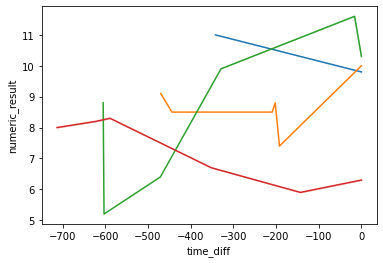

In [71]:
sample_data_1=df_HbA1C_final[df_HbA1C_final.patient_sk.isin(df_HbA1C_final.patient_sk.unique()[4:8])][['patient_sk','numeric_result','time_diff']]
sns.lineplot(data=sample_data_1, x="time_diff", y="numeric_result", hue="patient_sk",legend=False)

<AxesSubplot:xlabel='time_diff', ylabel='numeric_result'>

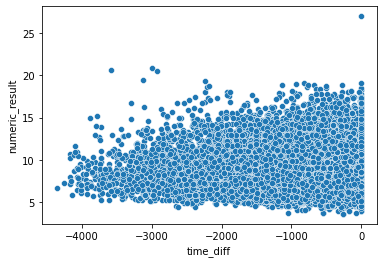

In [69]:
sns.scatterplot(data=df_HbA1C_final,x="time_diff", y="numeric_result")

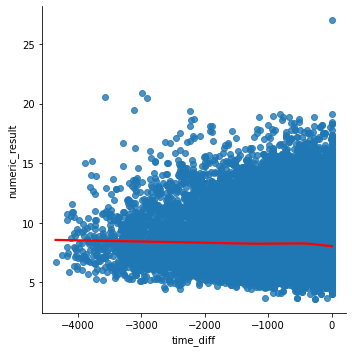

In [70]:
g2=sns.lmplot(data=df_HbA1C_final,x="time_diff", y="numeric_result",lowess=True,line_kws={"color":"red"})
g2

In [82]:
df_HbA1C_final

,encounter_id,patient_sk,lab_procedure_name,numeric_result,unit,lab_verified_dt_tm,dr_encounter,race,gender,age_in_years,admitted_dt_tm,last_time,time_diff
0,234836515,40184,Hemoglobin A1C (Glycosylated Hemoglobin),8.2,%,2012-03-01 20:12:00,0,Caucasian,Male,52.0,2011-12-07 11:01:00.0000000,2014-12-19 13:03:00,-1022
1,234836515,40184,Hemoglobin A1C (Glycosylated Hemoglobin),8.2,%,2012-03-01 20:12:00,0,Caucasian,Male,52.0,2011-12-07 11:01:00.0000000,2014-12-19 13:03:00,-1022
2,234826139,40184,Hemoglobin A1C (Glycosylated Hemoglobin),7.6,%,2012-05-02 16:44:00,0,Caucasian,Male,53.0,2012-03-07 09:51:00.0000000,2014-12-19 13:03:00,-960
3,234826139,40184,Hemoglobin A1C (Glycosylated Hemoglobin),7.6,%,2012-05-02 16:44:00,0,Caucasian,Male,53.0,2012-03-07 09:51:00.0000000,2014-12-19 13:03:00,-960
4,241041726,40184,Hemoglobin A1C (Glycosylated Hemoglobin),7.3,%,2012-05-29 15:27:00,0,Caucasian,Male,53.0,2012-05-07 13:00:00.0000000,2014-12-19 13:03:00,-933
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33193,11678788,84691264,Hemoglobin A1C (Glycosylated Hemoglobin),14.0,%,2009-04-05 20:43:00,0,Caucasian,Male,47.0,2009-03-07 19:57:00.0000000,2010-01-18 22:09:00,-288
33194,11678785,84691264,Hemoglobin A1C (Glycosylated Hemoglobin),5.9,%,2009-04-08 21:18:00,0,Caucasian,Male,47.0,2009-09-15 19:51:00.0000000,2010-01-18 22:09:00,-285
33195,12919455,84691264,Hemoglobin A1C (Glycosylated Hemoglobin),8.7,%,2009-06-11 22:25:00,0,Caucasian,Male,47.0,2009-05-14 00:00:00.0000000,2010-01-18 22:09:00,-220
33196,11678786,84691264,Hemoglobin A1C (Glycosylated Hemoglobin),7.1,%,2009-09-30 22:40:00,0,Caucasian,Male,47.0,2009-09-02 00:25:00.0000000,2010-01-18 22:09:00,-109


In [83]:
df_creat_final

,encounter_id,patient_sk,lab_procedure_name,unit,lab_verified_dt_tm,dr_encounter,race,gender,age_in_years,admitted_dt_tm,numeric_result,last_time,time_diff
0,242007621,40184,"Creatinine, Serum Quantitative",mg/dL,2011-04-18 15:25:00,0,Caucasian,Male,52.0,2011-09-23 08:41:00.0000000,0.70,2014-12-19 10:19:00,-1340
1,234836515,40184,"Creatinine, Serum Quantitative",mg/dL,2012-03-01 20:02:00,0,Caucasian,Male,52.0,2011-12-07 11:01:00.0000000,1.70,2014-12-19 10:19:00,-1022
2,241488258,40184,"Creatinine, Serum Quantitative",mg/dL,2012-03-13 08:22:00,0,Caucasian,Male,53.0,2012-03-13 06:13:00.0000000,1.60,2014-12-19 10:19:00,-1011
3,242047104,40184,"Creatinine, Serum Quantitative",mg/dL,2012-03-24 00:11:00,0,Caucasian,Male,52.0,2011-09-21 11:28:00.0000000,0.90,2014-12-19 10:19:00,-1000
4,241110926,40184,"Creatinine, Serum Quantitative",mg/dL,2012-04-13 08:49:00,0,Caucasian,Male,53.0,2012-04-05 08:59:00.0000000,2.20,2014-12-19 10:19:00,-980
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145525,445096412,104656321,"Creatinine, Serum Quantitative",mg/dL,2015-06-22 04:38:00,1,Caucasian,Male,48.0,2015-06-15 12:47:00.0000000,5.00,2015-06-22 04:38:00,0
145526,444412882,104700366,"Creatinine, Serum Quantitative",mg/dL,2015-04-02 05:38:00,0,African American,Female,53.0,2015-03-30 01:10:00.0000000,3.29,2015-06-22 03:37:00,-80
145527,444676159,104700366,"Creatinine, Serum Quantitative",mg/dL,2015-04-15 04:49:00,0,African American,Female,53.0,2015-04-08 19:26:00.0000000,2.27,2015-06-22 03:37:00,-67
145528,444820403,104700366,"Creatinine, Serum Quantitative",mg/dL,2015-05-15 13:32:00,0,Caucasian,Female,53.0,2015-05-15 12:53:00.0000000,2.69,2015-06-22 03:37:00,-37


# White Blood Cell Count

In [72]:
dr_wbc=dr[dr["lab_procedure_name"]=='White Blood Cell Count']
dr_wbc=dr_wbc.sort_values(by=['patient_sk','lab_verified_dt_tm']).dropna()

In [73]:
dr_wbc.unit.unique()

array(['10*3', '10*3/uL', '/mm3', 'Not Mapped', 'K/mm3', '10*9', '[HPF]',
       '/uL', 'U/L', '10*9/L', 'K/mcL dup', 'm', 'mm3', 'kg', 'nL',
       '{Cells}', '/L', 'KLK units/mL', '10*6/uL'], dtype=object)

In [92]:
dr_wbc=dr_wbc[dr_wbc.unit.isin(['10*3','10*3/uL','/mm3','K/mm3','10*9','10*9/L','K/mcL dup','K/mm3'])]

In [93]:
dr_wbc.groupby('unit').count()

,encounter_id,patient_sk,lab_procedure_name,numeric_result,lab_verified_dt_tm,dr_encounter,race,gender,age_in_years,admitted_dt_tm
unit,,,,,,,,,,
/mm3,40845,40845,40845,40845,40845,40845,40845,40845,40845,40845
10*3,206790,206790,206790,206790,206790,206790,206790,206790,206790,206790
10*3/uL,222671,222671,222671,222671,222671,222671,222671,222671,222671,222671
10*9,89845,89845,89845,89845,89845,89845,89845,89845,89845,89845
10*9/L,58144,58144,58144,58144,58144,58144,58144,58144,58144,58144
K/mcL dup,71940,71940,71940,71940,71940,71940,71940,71940,71940,71940
K/mm3,136818,136818,136818,136818,136818,136818,136818,136818,136818,136818


In [94]:
dr_wbc_prep=dr_wbc.groupby("encounter_id").first().sort_values(by=['patient_sk','lab_verified_dt_tm']).reset_index()
dr_wbc_mean=dr_wbc.groupby('encounter_id').mean()
dr_wbc_final=dr_wbc_prep.merge(dr_wbc_mean,how='left',on='encounter_id').drop(columns=['numeric_result_x','patient_sk_y','dr_encounter_y','age_in_years_y'])
dr_wbc_final.rename(columns={'patient_sk_x':'patient_sk','dr_encounter_x':'dr_encounter','age_in_years_x':'age_in_years','numeric_result_y':'numeric_result'},inplace=True)

In [95]:
df_wbc=pd.DataFrame()
for key in dr_wbc.patient_sk.unique():
    if ((len(dr_wbc[dr_wbc.patient_sk==key].encounter_id.unique())>=3) and (dr_wbc[dr_wbc.patient_sk==key].dr_encounter.sum()>0)) :
        en_id=dr_wbc[(dr_wbc.patient_sk==key)&(dr_wbc.dr_encounter==True)].iloc[0]["encounter_id"]
        time=dr_wbc[dr_wbc.encounter_id==en_id].lab_verified_dt_tm.max()
        df_patient=dr_wbc[(dr_wbc.patient_sk==key)&(dr_wbc.lab_verified_dt_tm<=time)]
        df_wbc=df_wbc.append(df_patient,ignore_index=True)

In [98]:
countdf =df_wbc.groupby('patient_sk').count()
df_wbc_final = df_wbc.loc[df_wbc['patient_sk'].isin(countdf[countdf['encounter_id'] > 3].index)]

In [99]:
df_wbc_final=df_wbc_final.reset_index()
df_wbc_lt=df_wbc_final.groupby('patient_sk').lab_verified_dt_tm.max().reset_index()
df_wbc_lt=df_wbc_lt.rename(columns={'lab_verified_dt_tm':'last_time'})
df_wbc_merge=df_wbc_final.merge(df_wbc_lt,how='left',on='patient_sk')
df_wbc_final=df_wbc_merge.drop(columns='index')

In [100]:
df_wbc_final['lab_verified_dt_tm']=pd.to_datetime(df_wbc_final['lab_verified_dt_tm'])
df_wbc_final['last_time']=pd.to_datetime(df_wbc_final['last_time'])
df_wbc_final['time_diff']=-(df_wbc_final['last_time']-df_wbc_final['lab_verified_dt_tm']).dt.days
df_wbc_final['patient_sk']=df_wbc_final.patient_sk.astype(str)

<AxesSubplot:xlabel='time_diff', ylabel='numeric_result'>

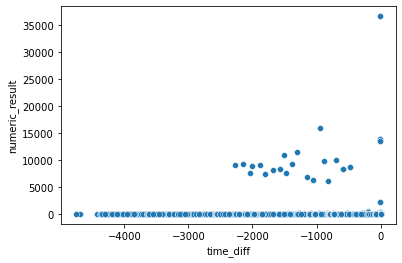

In [101]:
sns.scatterplot(data=df_wbc_final,x="time_diff", y="numeric_result")

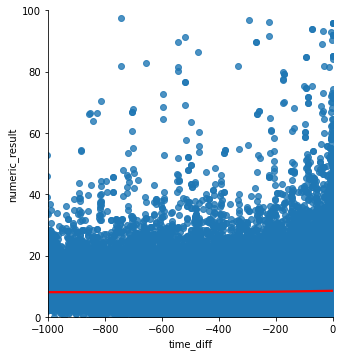

In [102]:
g3=sns.lmplot(data=df_wbc_final,x="time_diff", y="numeric_result",lowess=True,line_kws={"color":"red"})
g3.set(ylim=(0,100),xlim=(-1000,0))

# Glucose

In [104]:
dr_glucose=dr[dr['lab_procedure_name']=='Glucose, Serum/Plasma Quantitative'].sort_values(by=['patient_sk','lab_verified_dt_tm']).dropna()
dr_glucose=dr_glucose[dr_glucose['unit']=='mg/dL']

In [105]:
dr_glucose_prep=dr_glucose.groupby("encounter_id").first().sort_values(by=['patient_sk','lab_verified_dt_tm']).reset_index()
dr_glucose_mean=dr_glucose.groupby('encounter_id').mean()
dr_glucose_final=dr_glucose_prep.merge(dr_glucose_mean,how='left',on='encounter_id').drop(columns=['numeric_result_x','patient_sk_y','dr_encounter_y','age_in_years_y'])
dr_glucose_final.rename(columns={'patient_sk_x':'patient_sk','dr_encounter_x':'dr_encounter','age_in_years_x':'age_in_years','numeric_result_y':'numeric_result'},inplace=True)

In [ ]:
df_glucose=pd.DataFrame()
for key in dr_glucose.patient_sk.unique():
    if ((len(dr_glucose[dr_glucose.patient_sk==key].encounter_id.unique())>=3) and (dr_glucose[dr_glucose.patient_sk==key].dr_encounter.sum()>0)) :
        en_id=dr_glucose[(dr_glucose.patient_sk==key)&(dr_glucose.dr_encounter==True)].iloc[0]["encounter_id"]
        time=dr_glucose[dr_glucose.encounter_id==en_id].lab_verified_dt_tm.max()
        df_patient=dr_glucose[(dr_glucose.patient_sk==key)&(dr_glucose.lab_verified_dt_tm<=time)]
        df_glucose=df_glucose.append(df_patient,ignore_index=True)

In [ ]:
countdf =df_glucose.groupby('patient_sk').count()
df_glucose_final = df_glucose.loc[df_glucose['patient_sk'].isin(countdf[countdf['encounter_id'] > 3].index)]

In [ ]:
df_wbc_final=df_wbc_final.reset_index()
df_wbc_lt=df_wbc_final.groupby('patient_sk').lab_verified_dt_tm.max().reset_index()
df_wbc_lt=df_wbc_lt.rename(columns={'lab_verified_dt_tm':'last_time'})
df_wbc_merge=df_wbc_final.merge(df_wbc_lt,how='left',on='patient_sk')
df_wbc_final=df_wbc_merge.drop(columns='index')

In [ ]:
df_glucose_final['lab_verified_dt_tm']=pd.to_datetime(df_glucose_final['lab_verified_dt_tm'])
df_glucose_final['last_time']=pd.to_datetime(df_glucose_final['last_time'])
df_glucose_final['time_diff']=-(df_glucose_final['last_time']-df_glucose_final['lab_verified_dt_tm']).dt.days
df_glucose_final['patient_sk']=df_glucose_final.patient_sk.astype(str)

In [ ]:
sns.scatterplot(data=df_glucose_final,x="time_diff", y="numeric_result")

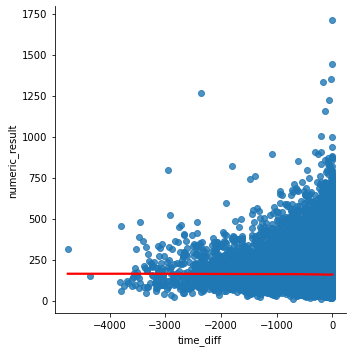

In [175]:
sns.lmplot(data=df_glucose_final,x="time_diff", y="numeric_result",lowess=True,line_kws={"color":"red"})

In [204]:
df_creat_final.to_csv('df_creat_final.csv')

In [184]:
patient_int=list(set(df_creat_final.patient_sk.unique())&set(df_HbA1C_final.patient_sk.unique())&set(df_wbc_final.patient_sk.unique())&set(df_glucose_final.patient_sk.unique()))